In [7]:
import pandas as pd
from darts import TimeSeries

from darts.models.forecasting.xgboost import XGBModel
from darts.utils.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
product_type = "SRL_NEG_00_04"

df_raw = pd.read_csv(f'data/processed/{product_type}.csv')

In [3]:
series = TimeSeries.from_dataframe(df_raw, 'date', 'capacity_price')

In [4]:
train, val = train_test_split(series, test_size=0.2)
val, test = train_test_split(val, test_size=0.5)

In [5]:
model = XGBModel(lags=10, eta=0.4)
model.fit(train)
pred = model.predict(len(val))

In [6]:
date_index = val.time_index

In [7]:
_pred = pred.pd_dataframe()['capacity_price']
_val = val.pd_dataframe()['capacity_price']

In [8]:
diff = _pred - _val

naive_pred = _val.shift(1, fill_value=13.92)
naive_diff = naive_pred - _val

predicted_revenue = np.where(diff > 0, 0, _pred).sum(0).round(2)
predicted_naive = np.where(naive_diff > 0, 0, naive_pred).sum(0).round(2)

In [9]:
predicted_revenue

849.36

In [10]:
p_r = np.where(diff > 0, 0, _pred).sum(0).round(2)

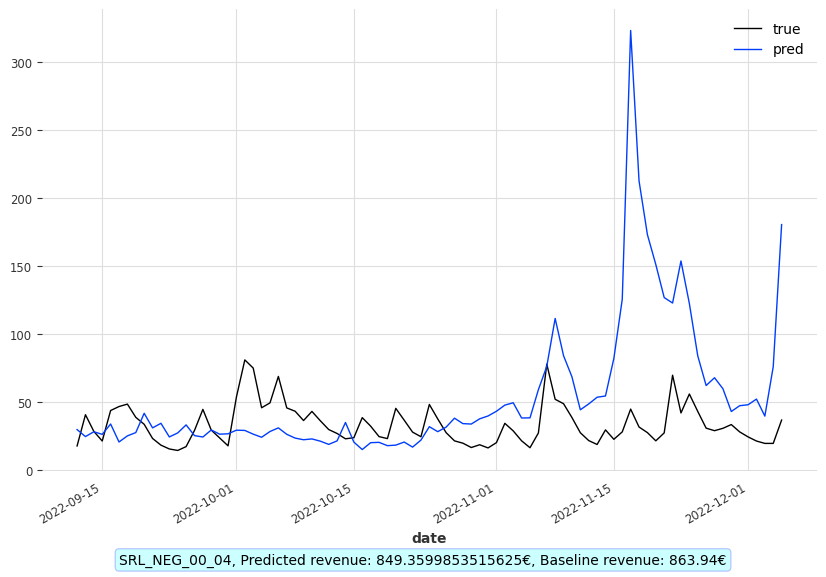

<Figure size 640x480 with 0 Axes>

In [20]:
fig = plt.subplots(figsize=(10, 6))
val.plot(label='true', lw=1)
pred.plot(label='pred', lw=1)

plt.annotate(f'{product_type}, Predicted revenue: {predicted_revenue}€, Baseline revenue: {predicted_naive}€', 
                xy=(0.1, -0.2), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="cyan", ec="b", lw=1, alpha=0.2))

plt.show()
plt.savefig('hello')

In [2]:
import numpy as np
from datetime import datetime
from utils.postprocessing import ProcessedResultXGB
from darts.models.forecasting.xgboost import XGBModel
import pickle as pkl
from data.data_loader import Dataset_SRL_XGBoost
import argparse

In [8]:
args_dict = dict(
    # product_type='SRL_NEG_00_04',
    lags=10,
    max_depth=6,
    eta=0.3,
    n_estimators=100,
    subsample=1,
    colsample_bytree=1,
    reg_alpha=1,
    reg_lambda=1,
    objective=custom_obj,
)

In [23]:
class Args():
    def __init__(self, args_dict):
        for key, value in args_dict.items():
            setattr(self, key, value)
            
args = Args(args_dict)

In [4]:
dataset = Dataset_SRL_XGBoost(root_path='C:/codes/srl_informer/data/processed/', product_type=args.product_type)

model = CustomXGBRegressor(
    lags=args.lags,
    max_depth=args.max_depth,
    eta=args.eta,
    n_estimators=args.n_estimators,
    subsample=args.subsample,
    colsample_bytree=args.colsample_bytree,
    reg_alpha=args.reg_alpha,
    reg_lambda=args.reg_lambda,
    objective=custom_obj
)

NameError: name 'args' is not defined

In [10]:
model = CustomXGBRegressor(params=args_dict, lags=10)

ValueError: At least one of `lags`, `lags_future_covariates` or `lags_past_covariates` must be not None.


ValueError: At least one of `lags`, `lags_future_covariates` or `lags_past_covariates` must be not None.

In [5]:
import numpy as np
import xgboost as xgb

# Define the custom objective function
def custom_obj(preds, dtrain):
    labels = dtrain.get_label()
    grad = (preds - labels) / np.square(labels)
    hess = np.ones_like(labels) / np.square(labels)
    return grad, hess

params = {"objective": "reg:squarederror", "eval_metric": "rmse"}

model.fit(dataset.train)

NameError: name 'model' is not defined

In [6]:
import numpy as np
from darts.models.forecasting.regression_model import RegressionModel
import xgboost as xgb

class CustomXGBRegressor(RegressionModel):
    def __init__(self, params=None, lags=None):
        super().__init__()
        if params is None:
            params = {}
        self.params = params
        self.lags = lags

    def fit(self, x, y):
        # Convert data to DMatrix format
        dtrain = xgb.DMatrix(x, label=y)

        # Define the custom objective function
        def custom_objective(y_true, y_pred):
            errors = y_true - y_pred
            grad = -2 * errors
            hess = 2 * np.ones_like(errors)
            return grad, hess

        # Set the custom objective function in the parameters
        self.params['objective'] = custom_objective

        # Train the XGBoost model
        self.model = xgb.train(params=self.params, dtrain=dtrain)

    def predict(self, x):
        # Convert data to DMatrix format
        dtest = xgb.DMatrix(x)

        # Make predictions using the XGBoost model
        y_pred = self.model.predict(dtest)

        return y_pred


## Low-level XGBoost

In [8]:
def get_indices_entire_sequence(
    data: pd.DataFrame, 
    window_size: int, 
    step_size: int
    ) -> list:
        """
        Produce all the start and end index positions that is needed to produce
        the sub-sequences. 
        Returns a list of tuples. Each tuple is (start_idx, end_idx) of a sub-
        sequence. These tuples should be used to slice the dataset into sub-
        sequences. These sub-sequences should then be passed into a function
        that slices them into input and target sequences. 
        
        Args:
            data (pd.DataFrame): Partitioned data set, e.g. training data
            
            window_size (int): The desired length of each sub-sequence. Should be
                               (input_sequence_length + target_sequence_length)
                               E.g. if you want the model to consider the past 100
                               time steps in order to predict the future 50 
                               time steps, window_size = 100+50 = 150
            step_size (int): Size of each step as the data sequence is traversed 
                             by the moving window.
                             If 1, the first sub-sequence will be [0:window_size], 
                             and the next will be [1:window_size].
        Return:
            indices: a list of tuples
        """

        stop_position = len(data)-1 # 1- because of 0 indexing
        
        # Start the first sub-sequence at index position 0
        subseq_first_idx = 0
        
        subseq_last_idx = window_size
        
        indices = []
        
        while subseq_last_idx <= stop_position:

            indices.append((subseq_first_idx, subseq_last_idx))
            
            subseq_first_idx += step_size
            
            subseq_last_idx += step_size

        return indices

In [9]:
def get_xgboost_x_y(
    indices: list, 
    data: np.array,
    target_sequence_length,
    input_seq_len: int
    ):

    """
    Args:
        indices: List of index positions at which data should be sliced
        data: A univariate time series
        target_sequence_length: The forecasting horizon, m
        input_seq_len: The length of the model input, n
    Output: 
        all_x: np.array of shape (number of instances, input seq len)
        all_y: np.array of shape (number of instances, target seq len)
    """
    print("Preparing data..")

    # Loop over list of training indices
    for i, idx in enumerate(indices):

        # Slice data into instance of length input length + target length
        data_instance = data[idx[0]:idx[1]]

        x = data_instance[0:input_seq_len]

        assert len(x) == input_seq_len

        y = data_instance[input_seq_len:input_seq_len+target_sequence_length]

        # Create all_y and all_x objects in first loop iteration
        if i == 0:

            all_y = y.reshape(1, -1)

            all_x = x.reshape(1, -1)

        else:

            all_y = np.concatenate((all_y, y.reshape(1, -1)), axis=0)

            all_x = np.concatenate((all_x, x.reshape(1, -1)), axis=0)

    print("Finished preparing data!")

    return all_x, all_y

In [14]:
from data.data_loader import Dataset_SRL_XGBoost

data = Dataset_SRL_XGBoost(product_type='SRL_NEG_00_04', root_path='data/processed/SRL/')

hyperparameters = {
    'target_seq_len': 10,
    'input_seq_len': 20,
    "in_length" : 7*24,
    "step_size" : 12,
    "n_estimators" : 20,
    "max_depth" : 6,
    "subsample" : 0.5,
    "min_child_weight" : 1,
    }

In [20]:
idx_train = get_indices_entire_sequence(data.train, window_size=30, step_size=1)
x_train, y_train = get_xgboost_x_y(
    indices=idx_train, 
    data=data.train.values(),
    target_sequence_length=1,
    input_seq_len=4
    )

idx_test = get_indices_entire_sequence(data.test, window_size=30, step_size=1)
x_test, y_test = get_xgboost_x_y(
    indices=idx_test, 
    data=data.test.values(),
    target_sequence_length=1,
    input_seq_len=20
    )

Preparing data..
Finished preparing data!
Preparing data..
Finished preparing data!


In [66]:
def linex_loss(a):
    """Linear-exponential loss function with "weight" parameter a
    The larger a is the more positive errors are penalized
    When a is small, loss function looks like normal quadratic loss
    Args:
        a (float): positive, range from 0.001
    """
    def loss(y_pred, y_true):
        residual = y_pred - y_true # this order matters
        grad = -(2/a) * ( np.exp(a * residual) - 1 )
        hess = 2 * np.exp( a * residual )
        return grad, hess
    
    return loss

In [67]:
custom_linex = linex_loss(0.05)

In [69]:
model = xgb.XGBRegressor(
    n_estimators=hyperparameters["n_estimators"],
    max_depth=hyperparameters["max_depth"],
    subsample=hyperparameters["subsample"],
    min_child_weight=hyperparameters["min_child_weight"],
    objective=custom_linex,
    eval_metric=mean_absolute_error,
    tree_method="hist"
    )

# hyperparameters = {
#     'target_seq_len': 10,
#     'input_seq_len': 20,
#     "in_length" : 7*24,
#     "step_size" : 12,
#     "n_estimators" : 20,
#     "max_depth" : 6,
#     "subsample" : 0.5,
#     "min_child_weight" : 1,
#     }
trained_model = MultiOutputRegressor(model).fit(x_train, y_train)

train_forecasts = trained_model.predict(x_train)

pred = trained_model.predict(x_test)

ValueError: Feature shape mismatch, expected: 4, got 20

In [129]:
y_train[:10]

array([[26.  ],
       [80.  ],
       [54.  ],
       [38.25],
       [35.  ],
       [34.08],
       [28.28],
       [23.14],
       [24.99],
       [24.38]])

In [130]:
train_forecasts[:10]

array([[26.900608 ],
       [77.66723  ],
       [67.97495  ],
       [56.37943  ],
       [26.983862 ],
       [15.8600025],
       [30.709562 ],
       [18.22933  ],
       [34.554184 ],
       [61.1401   ]], dtype=float32)

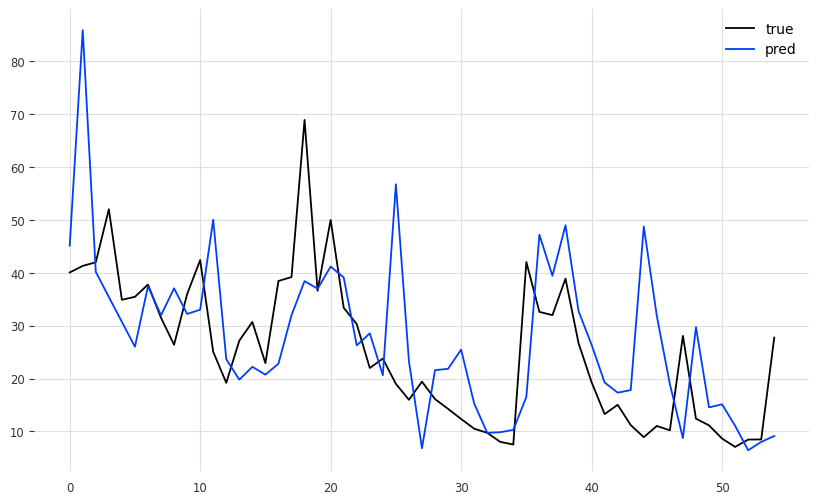

In [131]:
plt.subplots(figsize=(10, 6))
plt.plot(y_test, label='true')
plt.plot(pred, label='pred')
plt.legend()

In [77]:
import argparse
import os
import torch
import yaml

from utils.tools import autoimport

import numpy as np
from datetime import datetime

now = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

from exp.exp_informer import Exp_Informer
autoimport('data.data_loader')
from data.data_loader import Dataset_Informer, Dataset_XGB

root_path = os.path.normpath("data/processed/SRL/")

from sklearn.metrics import mean_absolute_error

def xgboost_model(args, objective='reg:squarederror'):


    
    return model

class Exp_XGBoost():
    def __init__(self, args):
        self.args = args
        self.model = self._build_model()
        
    def _build_model(self):
        model = xgb.XGBRegressor(
            n_estimators=args.n_estimators,
            max_depth=args.max_depth,
            subsample=args.subsample,
            min_child_weight=args.min_child_weight,
            learning_rate=args.learning_rate,
            objective='reg:squarederror', # either 'reg:squarederror' or custom objective
            eval_metric=mean_absolute_error, # function, e.g. from sk.metrics
            tree_method="hist"
        )
        
        return MultiOutputRegressor(model)
    
    def _get_data(self, flag):
        data_set = Dataset_XGB(
            root_path=self.args.root_path,
            data_path=args.data_path,
            flag='train',
            size=[args.input_len,args.target_len],
            features='S',
            target='capacity_price',
            timeenc=1,
            freq='d',
            scale='standard',
            cols=None
        )
    
    def train(self):
        train_data = self._get_data('train')
        trained_model = self.model.fit(train_data.matrix_x, train_data.matrix_y)
        print('Finished')

In [78]:
data_set.seqs_x[0]

array([[ 0.56680667],
       [ 1.94157537],
       [ 0.89825084],
       [ 0.17504659],
       [-0.04462539],
       [-0.14771397],
       [-0.19242285],
       [-0.17065514],
       [-0.19177745],
       [-0.22627721],
       [-0.24059344],
       [-0.24810359],
       [-0.25749128],
       [ 0.12857752],
       [ 0.41020825],
       [ 0.02589964],
       [-0.1568083 ],
       [ 0.27678569],
       [-0.03201068],
       [-0.18825706]])

In [73]:
hyperparameters = {
    'target_seq_len': 10,
    'input_seq_len': 20,
    "in_length" : 7*24,
    "step_size" : 12,
    "n_estimators" : 20,
    "max_depth" : 6,
    "subsample" : 0.5,
    "min_child_weight" : 1,
    }

model = xgb.XGBRegressor(
    n_estimators=hyperparameters["n_estimators"],
    max_depth=hyperparameters["max_depth"],
    subsample=hyperparameters["subsample"],
    min_child_weight=hyperparameters["min_child_weight"],
    objective='reg:squarederror',
    eval_metric=mean_absolute_error,
    tree_method="hist"
    )

trained_model = MultiOutputRegressor(model).fit(data_set.matrix_x, data_set.matrix_y)

train_forecasts = trained_model.predict(data_set.matrix_x)

# pred = trained_model.predict(x_test)